<h1>The Roots package</h1>

<p>The <code>Roots</code> package contains simple routines for finding zeros of continuous scalar functions of a single real variable.  A zero of $f$ is a value $c$ where $f(c) = 0$.  The basic interface is through the function <code>find_zero</code>, which through multiple dispatch can handle many different cases.</p>

<p>In the following, we will use <code>Plots</code> for plotting and <code>ForwardDiff</code> to take derivatives.</p>

In [1]:
using Roots
using Plots, ForwardDiff; pyplot();

Plots.PyPlotBackend()

<h2>Bracketing</h2>

<p>For a function $f$ (univariate, real-valued) a <em>bracket</em> is a pair $ a < b $ for which $f(a) \cdot f(b) < 0$. That is the function values have different signs at $a$ and $b$. If $f$ is a continuous function this ensures (<a href="https://en.wikipedia.org/wiki/Intermediate_value_theorem">Bolzano</a>) there will be a zero in the interval $[a,b]$.  If $f$ is not continuous, then there must be a point $c$ in $[a,b]$ where the function "jumps" over $0$.</p>

<p>Such values can be found, up to floating point roundoff. That is, given <code>f&#40;a&#41; * f&#40;b&#41; &lt; 0</code>, a value <code>c</code> with <code>a &lt; c &lt; b</code> can be found where either <code>f&#40;c&#41; &#61;&#61; 0.0</code> or  <code>f&#40;prevfloat&#40;c&#41;&#41; * f&#40;c&#41; &lt; 0</code> or <code>f&#40;c&#41; * f&#40;nextfloat&#40;c&#41;&#41; &lt; 0</code>.</p>

<p>To illustrate, consider the function $f(x) = \cos(x) - x$. From the graph we see readily that $[0,1]$ is a bracket (which we emphasize with an overlay):</p>

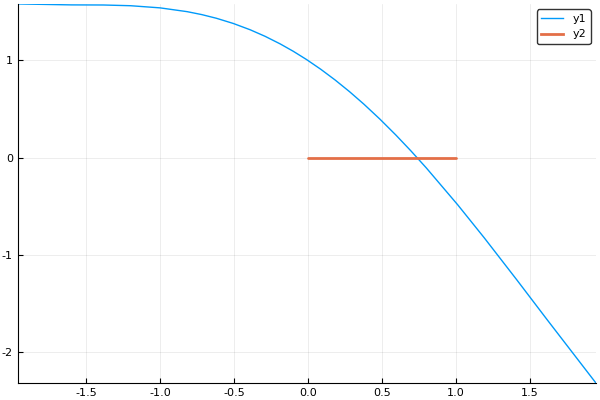

In [1]:
f(x) = cos(x) - x
plot(f, -2, 2)
plot!([0,1], [0,0], linewidth=2)

<p>The <code>Roots</code> package includes the bisection algorithm through <code>find_zero</code>. We use a vector or tuple to specify the initial condition and <code>Bisection&#40;&#41;</code> to specify the algorithm:</p>

In [1]:
x = find_zero(f, (0, 1), Bisection())    
x, f(x)

(0.7390851332151607, 0.0)

<p>For this function we see that <code>f&#40;x&#41;</code> is <code>0.0</code>.</p>

<hr />

<p>Next consider $f(x) = \sin(x)$. A known zero is $\pi$. Trigonometry tells us that $[\pi/2, 3\pi/2]$ will be a bracket. In this call <code>Bisection&#40;&#41;</code> is not specified, as it will be the default when the initial value is specified as a pair of numbers:</p>

In [1]:
f(x) = sin(x)
x = find_zero(f, (pi/2, 3pi/2))
x, f(x)

(3.141592653589793, 1.2246467991473532e-16)

<p>This value of <code>x</code> does not exactly produce a zero, however, it is as close as can be:</p>

In [1]:
f(prevfloat(x)) * f(x) < 0.0 || f(x) * f(nextfloat(x)) < 0.0

true

<p>That is, at <code>x</code> the function is changing sign.</p>

<p>From a mathematical perspective, a zero is guaranteed for a <em>continuous</em> function. However, the computer algorithm doesn't assume continuity, it just looks for changes of sign. As such, the algorithm will  identify discontinuities, not just zeros. For example:</p>

In [1]:
find_zero(x -> 1/x, (-1, 1))

-0.0

<p>The endpoints and function values can even be infinite:</p>

In [1]:
find_zero(x -> Inf*sign(x), (-Inf, Inf))  # Float64 only

-0.0

<p>The basic algorithm used for bracketing when the values are simple floating point values is a modification of the bisection method. For big float values, an algorithm due to Alefeld, Potra, and Shi is used.</p>

In [1]:
find_zero(sin, (big(3), big(4)))    # uses a different algorithm then for (3,4)

3.141592653589793238462643383279502884197169399375105820974944592307816406286198

<p>By default, bisection will converge to machine tolerance. This may provide more accuracy than desired. A tolerance may be specified to terminate early, thereby utilizing fewer resources. For example, this uses 19 steps to reach accuracy to $10^{-6}$ (without specifying <code>xatol</code> it uses 51 steps):</p>

In [1]:
rt = find_zero(sin, (3.0, 4.0), xatol=1e-6)
rt - pi

-6.27832957178498e-7

<h2>Non-bracketing problems</h2>

<p>Bracketing methods have guaranteed convergence, but in general require many more function calls than are needed to produce an answer.  If a good initial guess is known, then the <code>find_zero</code> function provides an interface to some different iterative algorithms that are more efficient. Unlike bracketing methods, these algorithms may not converge to the desired root if the initial guess is not well chosen.</p>

<p>The default algorithm is modeled after an algorithm used for <a href="http://www.hpl.hp.com/hpjournal/pdfs/IssuePDFs/1979-12.pdf">HP-34 calculators</a>. This algorithm is designed to be more forgiving of the quality of the initial guess at the cost of possibly performing many more steps than other algorithms, as if the algorithm encounters a bracket, bisection will be used.</p>

<p>For example, the answer to our initial problem is visibly seen from a graph to be near 1. Given this, the zero is found through:</p>

In [1]:
f(x) = cos(x) - x
x = find_zero(f , 1)
x, f(x)

(0.7390851332151607, 0.0)

<p>For the polynomial $f(x) = x^3 - 2x - 5$, an initial guess of 2 seems reasonable:</p>

In [1]:
f(x) = x^3 - 2x - 5
x = find_zero(f, 2)
x, f(x), sign(f(prevfloat(x)) * f(nextfloat(x)))

(2.0945514815423265, -8.881784197001252e-16, -1.0)

<p>For even more precision, <code>BigFloat</code> numbers can be used</p>

In [1]:
x = find_zero(sin, big(3))
x, sin(x), x - pi

(3.141592653589793238462643383279502884197169399375105820974944592307816406286198, 1.096917440979352076742130626395698021050758236508687951179005716992142688513354e-77, 0.000000000000000000000000000000000000000000000000000000000000000000000000000000)

<h3>Higher order methods</h3>

<p>The default call to <code>find_zero</code> uses a first order method and then possibly bracketing, which involves potentially many more function calls. There may be times where a more efficient algorithm is sought.  For such, a higher-order method might be better suited. There are algorithms <code>Order1</code> (secant method), <code>Order2</code> (<a href="http://en.wikipedia.org/wiki/Steffensen&#39;s_method">Steffensen</a>), <code>Order5</code>, <code>Order8</code>, and <code>Order16</code>. The order 1 or 2 methods are generally quite efficient. The even higher order ones are potentially useful when more precision is used. These algorithms are accessed by specifying the method after the initial starting point:</p>

In [1]:
f(x) = 2x - exp(-x)
x = find_zero(f, 1, Order1())     
x, f(x)

(0.35173371124919584, 0.0)

<p>The above makes $8$ function calls, to the $57$ made with <code>Order0</code>.</p>

In [1]:
f(x) = (x + 3) * (x - 1)^2
x = find_zero(f, -2, Order2())
x, f(x)

(-3.0, 0.0)

In [1]:
x = find_zero(f, 2, Order8())
x, f(x)

(1.0000000027152591, 2.949052856287529e-17)

<p>The latter shows that zeros need not be simple zeros  to be found. A simple zero, $c$,has $f(x) = (x-c) \cdot g(x)$ where $g(c) \neq 0$. Generally speaking, non-simple zeros are expected to take many more function calls, as the methods are no longer super-linear. This is the case here, where <code>Order2</code> uses $55$ function calls, <code>Order8</code> uses $41$, and <code>Order0</code> takes, a comparable, $42$.)</p>

<p>To investigate an algorithm and its convergence, the argument <code>verbose&#61;true</code> may be specified.</p>

<p>For some functions, adjusting the default tolerances may be necessary to achieve convergence. The tolerances include <code>atol</code> and <code>rtol</code>, which are used to check if $f(x_n) \approx 0$; <code>xatol</code> and <code>xrtol</code>, to check if $x_n \approx x_{n-1}$; and <code>maxevals</code> and <code>maxfnevals</code> to limit the number of steps in the algorithm or function calls.</p>

<h2>Classical methods</h2>

<p>The package provides some classical methods for root finding: <code>Roots.newton</code>, <code>Roots.halley</code>, and <code>Roots.secant_method</code>. (Currently these are not exported, so must be prefixed with the package name to be used.) We can see how each works on a problem studied by Newton himself. Newton's method uses the function and its derivative:</p>

In [1]:
f(x) = x^3 - 2x - 5
fp(x) = 3x^2 - 2
x = Roots.newton(f, fp, 2)
x, f(x)

(2.0945514815423265, -8.881784197001252e-16)

<p>To see the algorithm in progress, the argument <code>verbose&#61;true</code> may be specified.</p>

<p>Alternatively, <code>Roots.Newton&#40;&#41;</code> can be specified as the method for <code>find_zero</code>. The functions are specified using a tuple:</p>

In [1]:
find_zero((f,fp), 2, Roots.Newton())

2.0945514815423265

<p>The secant method typically needs two starting points, though a second one is computed if only one is give. Here we start with 2 and 3, specified through a tuple:</p>

In [1]:
x = Roots.secant_method(f, (2,3))
x, f(x)

(2.094551481542327, 3.552713678800501e-15)

<p>Starting with a single point is also supported:</p>

In [1]:
Roots.secant_method(f, 2)

2.0945514815423265

<p>(This is like <code>Order1&#40;&#41;</code>, but the implementation is significantly faster, as the framework is bypassed, and fewer checks on convergence are used. This method can be used when speed is very important.)</p>

<p>Halley's method has cubic convergence, as compared to Newton's quadratic convergence. It uses the second derivative as well:</p>

In [1]:
fpp(x) = 6x
x = Roots.halley(f, fp, fpp, 2)
x, f(x), sign(f(prevfloat(x)) * f(nextfloat(x)))

(2.0945514815423265, -8.881784197001252e-16, -1.0)

<p>(Halley's method takes 3 steps, Newton's 4, but Newton's uses 5 function calls to Halley's 10.)</p>

<p>For many functions, their derivatives can be computed automatically. The <code>ForwardDiff</code> package provides a means. Here we define an operator <code>D</code> to compute a derivative:</p>

In [1]:
using ForwardDiff
D(f) = x -> ForwardDiff.derivative(f, float(x))
D(f, n) = n > 1 ? D(D(f),n-1) : D(f)

D (generic function with 2 methods)

In [1]:
Roots.newton(f, D(f), 2)    

2.0945514815423265

<p>Or, for Halley's method:</p>

In [1]:
Roots.halley(f, D(f), D(f,2), 2)  

2.0945514815423265

<h2>Finding critical points</h2>

<p>The <code>D</code> function, defined above, makes it straightforward to find critical points (typically where the derivative is $0$ but also where it is undefined). For example, the critical point of the function $f(x) = 1/x^2 + x^3, x > 0$ near $1.0$ is where the derivative is $0$ and can be found through:</p>

In [1]:
f(x) = 1/x^2 + x^3
find_zero(D(f), 1)

0.9221079114817278

<p>For more complicated expressions, <code>D</code> will not work, and other means of finding a derivative can be employed. In this example, we have a function that models the flight of an arrow on a windy day:</p>

In [1]:
function flight(x, theta)
 	 k = 1/2
	 a = 200*cosd(theta)
	 b = 32/k
	 tand(theta)*x + (b/a)*x - b*log(a/(a-x))
end

flight (generic function with 1 method)

<p>The total distance flown is when <code>flight&#40;x&#41; &#61;&#61; 0.0</code> for some <code>x &gt; 0</code>: This can be solved for different <code>theta</code> with <code>find_zero</code>. In the following, we note that <code>log&#40;a/&#40;a-x&#41;&#41;</code> will have an asymptote at <code>a</code>, so we start our search at <code>a-5</code>:</p>

In [1]:
function howfar(theta)
	 a = 200*cosd(theta)
	 find_zero(x -> flight(x, theta), a-5)
end

howfar (generic function with 1 method)

<p>To visualize the trajectory if shot at 45 degrees, we have:</p>

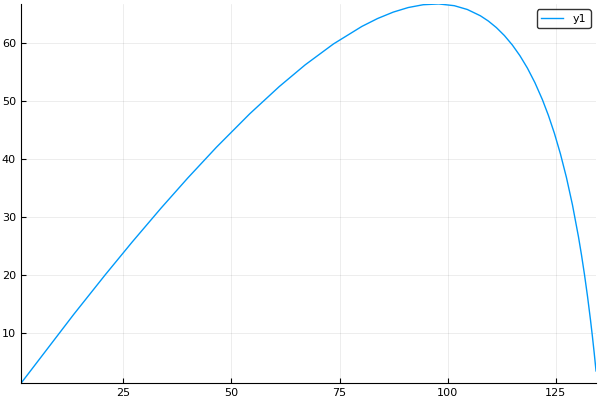

In [1]:
theta = 45
plot(x -> flight(x,  theta), 0, howfar(theta))

<p>To maximize the range we solve for the lone critical point of <code>howfar</code> within reasonable starting points. In this example, the derivative can not be taken automatically with <code>D</code>. So,  here we use a central-difference approximation and start the search at 45 degrees–the angle which maximizes the trajectory on a non-windy day:</p>

In [1]:
h = 1e-5
howfarp(theta) = (howfar(theta+h) - howfar(theta-h)) / (2h)
tstar = find_zero(howfarp, 45)

26.262308921132885

<p>This graph shows the differences in the trajectories:</p>

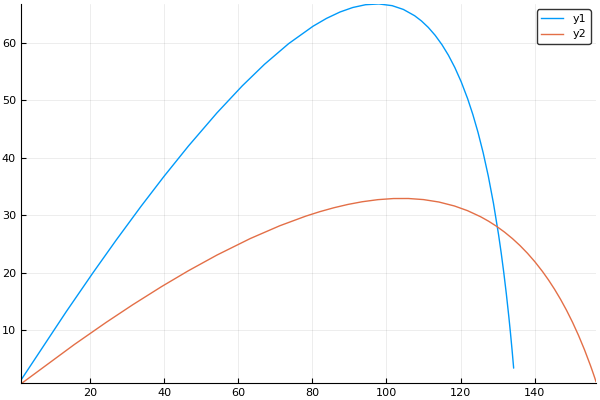

In [1]:
plot(x -> flight(x, 45), 0, howfar(45))  
plot!(x -> flight(x, tstar), 0, howfar(tstar))

<h2>Potential issues</h2>

<p>The higher-order methods are basically various derivative-free versions of Newton's method (which has update step $x - f(x)/f'(x)$). For example, Steffensen's method (<code>Order2&#40;&#41;</code>) essentially replaces $f'(x)$ with $(f(x + f(x)) - f(x))/f(x)$. This is a forward-difference approximation to the derivative with "$h$" being $f(x)$, which presumably is close to $0$ already. The methods with higher order combine this with different secant line approaches that minimize the number of function calls. These higher-order methods can be susceptible to some of the usual issues found with Newton's method: poor initial guess, small first derivative, or large second derivative near the zero.</p>

<p>When the first derivative is near $0$, the value of the next step can be quite different, as the next step generally tracks the intersection point of the tangent line. We see that starting at a $\pi/2$ causes this search to be problematic:</p>

In [1]:
find_zero(sin, pi/2, Order1())

Roots.ConvergenceFailed("Stopped at: xn = 1.7282686480730119e9")


<p>(Whereas, starting at <code>pi/2 &#43; 0.3</code>–where the slope of the tangent is sufficiently close to point towards $\pi$–will find convergence at $\pi$.)</p>

<p>For a classic example where a large second derivative is the issue, we have $f(x) = x^{1/3}$:</p>

In [1]:
f(x) = cbrt(x)
x = find_zero(f, 1, Order2())	# all of 2, 5, 8, and 16 fail or diverge towards infinity

Roots.ConvergenceFailed("Stopped at: xn = -2.1990233589964556e12")


<p>However, the default finds the root here, as a bracket is identified:</p>

In [1]:
x = find_zero(f, 1)
x,  f(x)

(0.0, 0.0)

<p>Finally, for many functions, all of these methods need a good initial guess. For example, the polynomial function $f(x) = x^5 - x - 1$ has its one zero near $1.16$. If we start far from it, convergence may happen, but it isn't guaranteed:</p>

In [1]:
f(x) = x^5 - x - 1
x0 = 0.1
find_zero(f, x0)

1.1673039782614185

<p>Whereas, </p>

In [1]:
find_zero(f, x0, Order2())

Roots.ConvergenceFailed("Stopped at: xn = -0.7503218333241642")


<p>A graph shows the issue. We have overlayed 15 steps of Newton's method, the other algorithms being somewhat similar:</p>

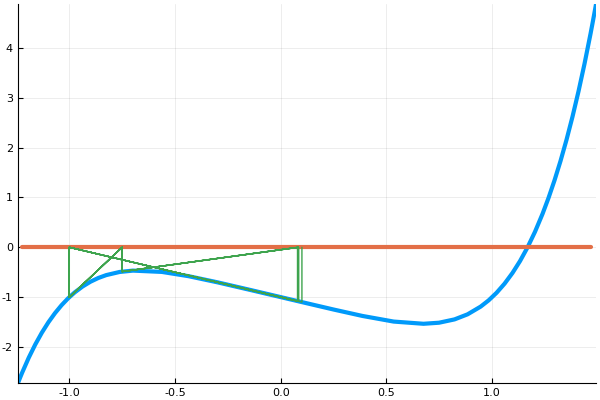

<p>Though 15 steps are shown, only a few are discernible, as the function's relative maximum causes a trap for this algorithm. Starting to the right of the relative minimum–nearer the zero–would avoid this trap. The default method employs a trick to bounce out of such traps, though it doesn't always work.</p>

<h3>Tolerances</h3>

<p>Mathematically solving for a zero of a nonlinear function may be impossible, so numeric methods are utilized. However, using floating point numbers to approximate the real numbers leads to some nuances.</p>

<p>For example, consider the polynomial $f(x) = (3x-1)^5$ with one zero at $1/3$ and its equivalent expression $f1(x) = -1 + 15\cdot x - 90\cdot x^2 + 270\cdot x^3 - 405\cdot x^4 + 243\cdot x^5$. Mathematically these are the same, however not so when evaluated in floating point. Here we look at the 21 floating point numbers near $1/3$:</p>

In [1]:
f(x) = (3x-1)^5
f1(x) =  -1 + 15*x - 90*x^2 + 270*x^3 - 405*x^4 + 243*x^5
ns = [1/3];
u=1/3; for i in 1:10 (u=nextfloat(u);push!(ns, u)) end
u=1/3; for i in 1:10 (u=prevfloat(u);push!(ns, u)) end
sort!(ns)

maximum(abs.(f.(ns) - f1.(ns)))

1.887379141862766e-15

<p>We see the function values are close for each point, as the maximum difference is like $10^{15}$. This is roughly as expected, where even one addition may introduce a relative error as big as $2\cdot 10^{-16}$ and here there are several such.</p>

<p>Generally this is not even a thought, as the differences are generally negligible, but when we want to identify if a value is zero, these small differences might matter. Here we look at the signs of the function values:</p>

In [1]:
fs = sign.(f.(ns))
f1s = sign.(f1.(ns))
[ns-1/3 fs f1s]

21×3 Array{Float64,2}:
 -5.55112e-16  -1.0  -1.0
 -4.996e-16    -1.0  -1.0
 -4.44089e-16  -1.0  -1.0
 -3.88578e-16  -1.0   1.0
 -3.33067e-16  -1.0   1.0
 -2.77556e-16  -1.0   1.0
 -2.22045e-16  -1.0  -1.0
 -1.66533e-16  -1.0  -1.0
 -1.11022e-16  -1.0   1.0
 -5.55112e-17  -1.0   1.0
  0.0           0.0   1.0
  5.55112e-17   0.0   1.0
  1.11022e-16   1.0   1.0
  1.66533e-16   1.0   1.0
  2.22045e-16   1.0  -1.0
  2.77556e-16   1.0  -1.0
  3.33067e-16   1.0   1.0
  3.88578e-16   1.0   1.0
  4.44089e-16   1.0   1.0
  4.996e-16     1.0   1.0
  5.55112e-16   1.0   0.0

<p>Parsing this shows a few surprises. First, there are two zeros of <code>f&#40;x&#41;</code> identified–not just one as expected mathematically–the floating point value of <code>1/3</code> and the next largest floating point number. For <code>f1&#40;x&#41;</code> there is only one zero, but it isn't the floating point value for <code>1/3</code> but rather 10 floating point numbers away. Further, there are 5 sign changes of the function values. There is no guarantee that a zero will be present, but for a mathematical function that changes sign, there will be at least one sign change.</p>

<p>With this in mind, an exact zero of <code>f</code> would be either where <code>iszero&#40;f&#40;x&#41;&#41;</code> is true <em>or</em> where the function has a sign change (either <code>f&#40;x&#41;*f&#40;prevfloat&#40;x&#41;&#41;&lt;0</code> or <code>f&#40;x&#41;*f&#40;nextfloat&#40;x&#41;&#41; &lt; 0</code>).</p>

<p>As mentioned, the default <code>Bisection&#40;&#41;</code> method of <code>find_zero</code> identifies such zeros for <code>f</code> provided an initial bracketing interval is specified when <code>Float64</code> numbers are used.  However, if a mathematical function does not cross the $x$ axis at a zero, then there is no guarantee the floating point values will satisfy either of these conditions.</p>

<p>Now consider the function <code>f&#40;x&#41; &#61; exp&#40;x&#41;-x^4</code>. The value<code>x&#61;8.613169456441398</code> is a zero in this sense, as there is a change of sign:</p>

In [1]:
f(x) = exp(x) - x^4
F(x) = sign(f(x))
x=8.613169456441398
F(prevfloat(x)), F(x), F(nextfloat(x))

(-1.0, -1.0, 1.0)

<p>However, the value of <code>f&#40;x&#41;</code> is not as small as one might initially expect for a zero:</p>

In [1]:
f(x)

-2.7284841053187847e-12

<p>The value <code>x</code> is an approximation to the actual mathematical zero, call it $x$. There is a difference between $f(x)$ (the mathematical answer) and <code>f&#40;x&#41;</code> (the floating point answer). Roughly speaking we expect <code>f&#40;x&#41;</code> to be about $f(x) + f'(x)\cdot \delta$, where $\delta$ is the difference between <code>x</code> and $x$. This will be on the scale of <code>abs&#40;x&#41; * eps&#40;&#41;</code>, so all told we expect an answer to be in the range of $0$ plus or minus this value:</p>

In [1]:
fp(x) = exp(x) - 4x^3 # the derivative
fp(x) * abs(x) * eps()

5.637565490466956e-12

<p>which is about what we see.</p>

<p>Bisection can be a slower method than others. For floating point values, <code>Bisection&#40;&#41;</code> takes no more than 64 steps, but other methods may be able to converge to a zero in 4-5 steps (assuming good starting values are specified).</p>

<p>When fewer function calls are desirable, then checking for an <em>approximate</em> zero may be preferred over assessing if a sign change occurs, as generally that will take two additional function calls per step. Besides, a sign change isn't guaranteed for all zeros. An approximate zero would be one where $f(x) \approx 0$.</p>

<p>By the above, we see that we must consider an appropriate tolerance. The first example shows differences in floating point evaluations from the mathematical ones might introduce errors on the scale of <code>eps</code> regardless of the size of <code>x</code>. As seen in the second example, the difference between the floating point approximation to the zero and the zero introduces a potential error <em>proportional</em> to the size of <code>x</code>. So a tolerance might consider both types of errors. An absolute tolerance is used as well as a relative tolerance, so a check might look like:</p>

In [1]:
abs(f(x)) < max(atol, abs(x) * rtol)

<p>This is different from <code>Julia</code>'s <code>isapprox&#40;f&#40;x&#41;, 0.0&#41;</code>, as that would use <code>abs&#40;f&#40;x&#41;&#41;</code> as the multiplier, which renders a relative tolerance useless for this question.</p>

<p>One issue with relative tolerances is that for functions with sublinear growth, extremely large values will be considered zeros. Returning to an earlier example, we have a misidentified zero:</p>

In [1]:
find_zero(cbrt, 1, Order8())

2.0998366730115564e23

<p>For <code>Order8</code>, the algorithm rapidly marches off towards infinity so the relative tolerance $\approx |x| \cdot \epsilon$ used to check if $f(x) \approx 0$ is large compared to the far-from zero $f(x)$.</p>

<p>Either the users must be educated about this possibility, or the relative tolerance should be set to $0$. In that case, the absolute tolerance must be relatively generous.  A conservative choice of absolute tolerance might be <code>sqrt&#40;eps&#40;&#41;&#41;</code>, or about <code>1e-8</code>, essentially the one made in SciPy.</p>

<p>This is not the choice made in <code>Roots</code>. The fact that bisection can produce zeros as exact as possible, and the fact that the error in function evaluation, $f'(x)|x|\epsilon$, is not typically on the scale of <code>1e-8</code>, leads to a desire for more precision, if available.</p>

<p>In <code>Roots</code>, the faster algorithms use a check on both the size of <code>f&#40;xn&#41;</code> and the size of the difference between the last two <code>xn</code> values. The check on <code>f&#40;xn&#41;</code> is done with a tight tolerance, as is the check on $x_n \approx x_{n-1}$. If the function values get close to zero, an approximate zero is declared. Further, if the $x$ values get close to each other <em>and</em> the function value is close to zero with a <em>relaxed</em> tolerance, then an approximate zero is declared. In practice this seems to work reasonably well. The relaxed tolerance uses the cube root of the absolute and relative tolerances.</p>

<h2>Searching for all zeros in an interval</h2>

<p>The methods described above are used to identify one of possibly several zeros.  The <code>find_zeros</code> function searches the interval $(a,b)$ for all zeros of a function $f$. It is straightforward to use:</p>

In [1]:
f(x) = exp(x) - x^4
a, b = -10, 10
zs = find_zeros(f, a, b)

3-element Array{Float64,1}:
 -0.815553
  1.42961 
  8.61317 

<p>The  search interval, $(a,b)$, is specified through two arguments. It is assumed that neither endpoint is a zero. Here we see the result of the search graphically:</p>

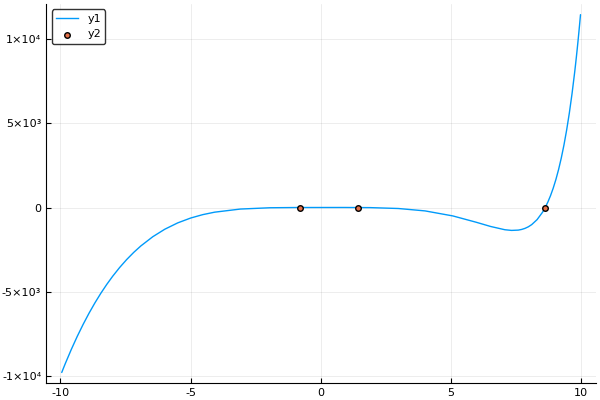

In [1]:
plot(f, a, b)
scatter!(zs, f.(zs))

<p>We can identify points where the first and second derivative is zero. We use <code>D</code> from above:</p>

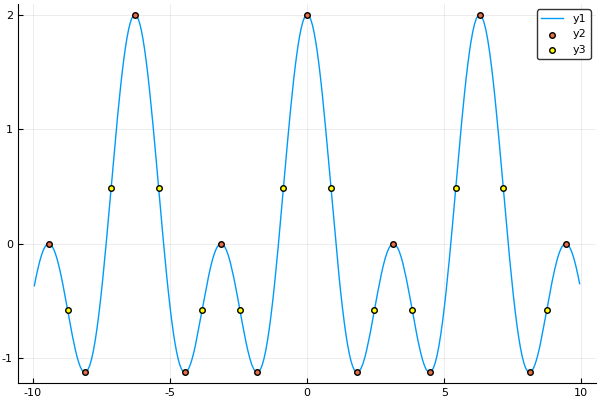

In [1]:
f(x) = cos(x) + cos(2x)
a, b = -10, 10
cps = find_zeros(D(f), a, b)
ips = find_zeros(D(f,2), a, b)
plot(f, a, b)
scatter!(cps, f.(cps))
scatter!(ips, f.(ips), markercolor = :yellow)

<p>The <code>find_zeros</code> algorithm will use bisection when a bracket is identified. This method will identify jumps, so areas where the derivative changes sign (and not necessarily a zero of the derivative) will typically be identified:</p>

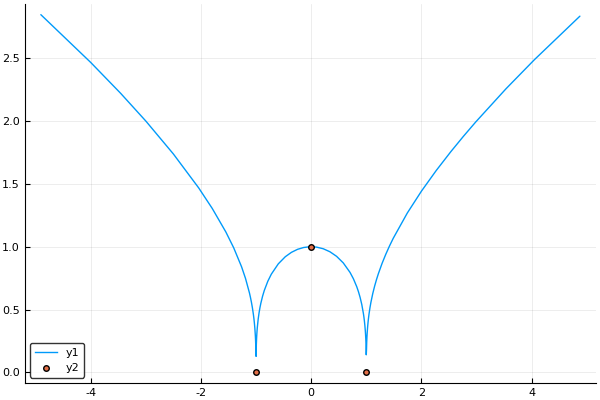

In [1]:
f(x) = abs(cbrt(x^2-1))
a, b = -5, 5
cps = find_zeros(D(f), a, b)
plot(f, a, b)
scatter!(cps, f.(cps))

<p>In this example, the derivative has vertical asymptotes at $x=1$ and $x=-1$ so is not continuous there. The bisection method identifies the zero crossing, not a zero.</p>

<p>The search for all zeros in an interval is confounded by a few things:</p>

<ul>
<li><p>too many zeros in the interval $(a,b)$</p>
</li>
<li><p>nearby zeros</p>
</li>
</ul>

<p>The algorithm is adaptive, so that it can succeed when there are many zeros, but it may be necessary to increase <code>no_pts</code> from the default of 12, at the cost of possibly taking longer for the search.</p>

<p>Here the algorithm identifies all the zeros, despite there being several:</p>

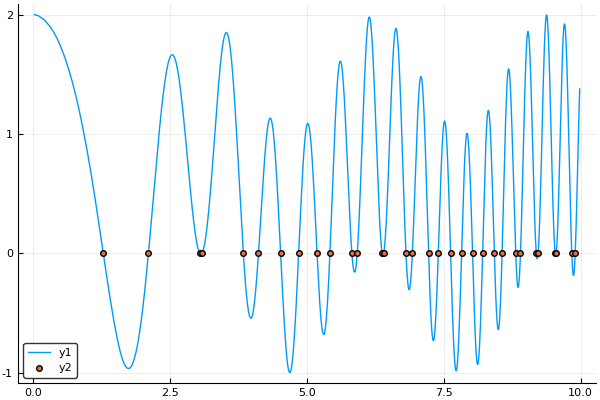

In [1]:
f(x) = cos(x)^2 + cos(x^2)
a, b = 0, 10
rts = find_zeros(f, a, b)
plot(f, a, b)
scatter!(rts, f.(rts))

<p>For nearby zeros, the algorithm does pretty well, though it isn't perfect.</p>

<p>Here we see for $f(x) = \sin(1/x)$–with infinitely many zeros around $0$–it finds many:</p>

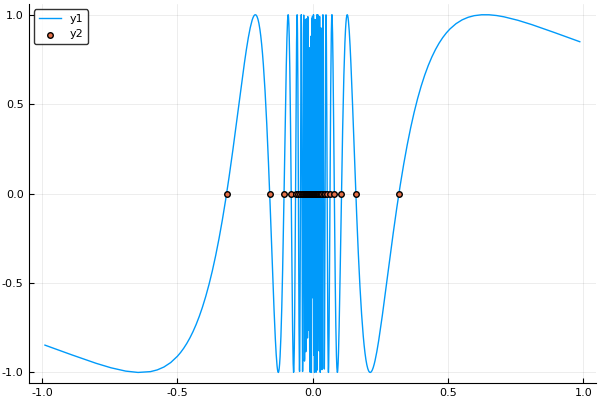

In [1]:
f(x) = iszero(x) ? NaN : sin(1/x)  # avoid sin(Inf) error
rts = find_zeros(f, -1, 1)  # 88 zeros identified
plot(f, -1, 1)
scatter!(rts, f.(rts))

<p>The function, $f(x) = (x-0.5)^3 \cdot (x-0.499)^3$, looks <em>too</em> much like $g(x) = x^6$ to <code>find_zeros</code> for success, as the two zeros are very nearby:</p>

In [1]:
f(x) =  (x-0.5)^3 * (x-0.499)^3
find_zeros(f, 0, 1)

1-element Array{Float64,1}:
 0.5

<p>The issue here isn't <em>just</em> that the algorithm can't identify zeros within $0.001$ of each other, but that the high power makes many nearby values approximately zero.</p>

<p>The algorithm will have success when the powers are smaller</p>

In [1]:
f(x) =  (x-0.5)^2 * (x-0.499)^2
find_zeros(f, 0, 1)

2-element Array{Float64,1}:
 0.499
 0.5  

<p>It can have success for closer pairs of zeros:</p>

In [1]:
f(x) = (x-0.5) * (x - 0.49999)
find_zeros(f, 0, 1)

2-element Array{Float64,1}:
 0.49999
 0.5    

<p>Combinations of large (even) multiplicity zeros or very nearby zeros, can lead to misidentification.</p>